## Выполнил Михаил Иванюта

## Проведение эксперимента из статьи
#### Модель реализована с использованием кода автора [статьи](https://arxiv.org/pdf/2003.00130.pdf), а также уже существующей реализации модели (https://github.com/vslaykovsky/translob). Архитектура соответствуют статье.

In [1]:
import math
import multiprocessing
from datetime import datetime

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Input, Model
from keras import backend as K
from keras import layers
from keras.layers import Layer
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.regularizers import L2
from sklearn.metrics import accuracy_score, classification_report
from keras.callbacks import EarlyStopping

from LobTransformer import TransformerBlock


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Подготовка данных
#### Берутся 40 признаков - 10 bid price, volume и 10 ask price, volume. 80% от тренирочного [датасета](https://etsin.fairdata.fi/dataset/73eb48d7-4dbc-4a10-a52a-da745b47a649) идут на обучение и 20% на валидацию.

In [16]:
def gen_data(data, horizon):
    x = data[:40, :].T
    y = data[-5 + horizon, :].T
    return x[:-1], (y[1:] - 1).astype(np.int32)

def load_dataset(horizon):
    dec_data = np.loadtxt('/content/drive/MyDrive/Dataset/Train_Dst_NoAuction_ZScore_CF_7.txt', dtype=float)
    dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
    dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]
    dec_test1 = np.loadtxt('/content/drive/MyDrive/Dataset/Test_Dst_NoAuction_ZScore_CF_7.txt', dtype=float)
    dec_test2 = np.loadtxt('/content/drive/MyDrive/Dataset/Test_Dst_NoAuction_ZScore_CF_8.txt', dtype=float)
    dec_test3 = np.loadtxt('/content/drive/MyDrive/Dataset/Test_Dst_NoAuction_ZScore_CF_9.txt', dtype=float)
    dec_test = np.hstack((dec_test1, dec_test2, dec_test3))
    return gen_data(dec_train, horizon), gen_data(dec_val, horizon), gen_data(dec_test, horizon)

### Создание, обучение и тестирование модели
#### Эксперимент проводится в соответствии со статьей. Архитектура и значения гиперпараметров взяты, как в статье, за исключением количества эпох. В данном эксперименте использую значение epochs = 40, ввиду технических ограничений. Также в статье приведен график, из которого следует, что при значении epochs ~ 40 из 150 величина accuracy стабилизируется. Проведение эксперимента при epochs = 150 можно увидеть в [translob_jupyter.ipynb](https://drive.google.com/file/d/1iS0QKVoWH1D4-zszUKDwcblbsnn_T-EK/view?usp=sharing).

Train (203799, 40) (203799,) Val (50949, 40) (50949,)
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 100, 40)]    0           []                               
                                                                                                  
 conv1d_35 (Conv1D)             (None, 100, 14)      1134        ['input_8[0][0]']                
                                                                                                  
 conv1d_36 (Conv1D)             (None, 100, 14)      406         ['conv1d_35[0][0]']              
                                                                                                  
 conv1d_37 (Conv1D)             (None, 100, 14)      406         ['conv1d_36[0][0]']              
                                      

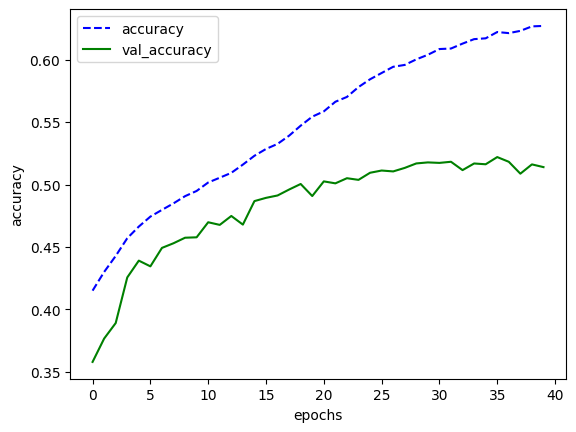

In [17]:
class PositionalEncodingLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x, *args, **kwargs):
        steps, d_model = x.shape.as_list()[-2:]
        ps = np.zeros([100, 1], dtype=K.floatx())
        for tx in range(100):
            ps[tx, :] = [(2 / (100 - 1)) * tx - 1]

        ps_expand = K.expand_dims(K.constant(ps), axis=0)
        ps_tiled = K.tile(ps_expand, [K.shape(x)[0], 1, 1])

        x = K.concatenate([x, ps_tiled], axis=-1)
        return x

def translob_model(**kwargs):
    inputs = Input(shape=(kwargs.get('sequence_length', 100), 40))
    x = inputs
    x = layers.Conv1D(14,kernel_size=2,dilation_rate=1,activation='relu',padding='causal')(x)
    x = layers.Conv1D(14,kernel_size=2,dilation_rate=2,activation='relu',padding='causal')(x)
    x = layers.Conv1D(14,kernel_size=2,dilation_rate=4,activation='relu',padding='causal')(x)
    x = layers.Conv1D(14,kernel_size=2,dilation_rate=8,activation='relu',padding='causal')(x)
    x = layers.Conv1D(14,kernel_size=2,dilation_rate=16,activation='relu',padding='causal')(x)
    x = layers.LayerNormalization()(x)
    x = PositionalEncodingLayer()(x)
    tb = TransformerBlock('tb1', kwargs.get('num_attention_heads', 3), True)
    blocks = kwargs.get('num_transformer_blocks', 2)
    for block in range(blocks):
        if kwargs.get('transformer_blocks_share_weights', True):
            x = tb(x)
        else:
            x = TransformerBlock(f'transformer_block_{block}', kwargs.get('num_attention_heads', 3), True)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64,activation='relu',kernel_regularizer='l2',kernel_initializer='glorot_uniform')(x)
    x = layers.Dropout(kwargs.get('dropout_rate', 0.1))(x)
    out = layers.Dense(3, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=out)
    model.summary()

    model.compile(
        tf.keras.optimizers.Adam(
            learning_rate=kwargs.get('lr', 0.0001),
            beta_1=kwargs.get('adam_beta1', 0.9),
            beta_2=kwargs.get('adam_beta2', 0.999),
            name="Adam",
        ),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['sparse_categorical_accuracy'],
    )

    return model

def train_translob(X_train, y_train, X_val, y_val, **kwargs):
    print('Train', X_train.shape, y_train.shape, 'Val', X_val.shape, y_val.shape)
    model = translob_model(**kwargs)
    length = kwargs.get('sequence_length', 100)
    train_gen = TimeseriesGenerator(X_train, y_train, length, shuffle=True, batch_size=kwargs.get('batch_size', 32))
    val_gen = TimeseriesGenerator(X_val, y_val, length, batch_size=kwargs.get('batch_size', 32))

    history = model.fit(
        train_gen,
        epochs=kwargs.get('epochs', 100),
        callbacks=[
            tf.keras.callbacks.TensorBoard(log_dir=(
                    "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
            ),
            tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', patience=10, min_delta=0.0002),
            EarlyStopping(monitor='val_sparse_categorical_accuracy', min_delta=0.001, patience=10, verbose=1, mode='auto')
        ],
        validation_data=val_gen
    )
    return model, history

def eval(model, X_test, y_test, **kwargs):
    ts = TimeseriesGenerator(X_test, y_test, kwargs.get('sequence_length', 100), batch_size=32, shuffle=False)
    y_true = np.concatenate([y for x, y in ts])
    y_pred = np.argmax(model.predict(ts), -1)
    print(classification_report(y_true, y_pred))
    return classification_report(y_true, y_pred, output_dict=True)['weighted avg']['f1-score']


(X_train, y_train), (X_val, y_val), (X_test, y_test) = load_dataset(horizon=4)

params = {
    # inputs
    'sequence_length': 100,
    # model
    'num_conv_filters': 14,
    'max_conv_dilation': 16,
    'num_attention_heads': 3,
    'num_transformer_blocks': 2,
    'transformer_blocks_share_weights': True,
    'dropout_rate': 0.1,
    # training
    'lr': 1e-4,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'batch_size': 32,
    'epochs': 40
}


model, history = train_translob(X_train, y_train, X_val, y_val, **params)
eval(model, X_test, y_test, **params)

plt.plot(history.history['sparse_categorical_accuracy'], '--b',label='accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], 'g', label='val_accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

#### Видно, что заявленные в статье значения метрик получить не удалось. В целом сложно выделить конкретные причины расхождения результата с точки зрения архитектуры сети и логики построения модели. Однако автор приводит только результаты и код отдельных компонент модели, поэтому возможно в статье упущена важная информация.

#### В статье не обосновывается выбор исключительно 10 bid price, volume и 10 ask price, volume в качестве признаков. Думаю, что этих признаков недостаточно. В качестве доказательства я обучил и протестировал модель на всех признаках, приведенных в датасете, но с измененными гиперпараметрами: learning_rate = 3e-4, batch_size = 16, epochs = 30. Данная модель показала себя лучше.

## Собственный эксперимент

### Подготовка данных
#### Берутся все признаки из датасета

In [14]:
def gen_data(data, horizon):
    x = data[:144, :].T
    y = data[-5 + horizon, :].T
    return x[:-1], (y[1:] - 1).astype(np.int32)

def load_dataset(horizon):
    dec_data = np.loadtxt('/content/drive/MyDrive/Dataset/Train_Dst_NoAuction_ZScore_CF_7.txt', dtype=float)
    dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
    dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]
    dec_test1 = np.loadtxt('/content/drive/MyDrive/Dataset/Test_Dst_NoAuction_ZScore_CF_7.txt', dtype=float)
    dec_test2 = np.loadtxt('/content/drive/MyDrive/Dataset/Test_Dst_NoAuction_ZScore_CF_8.txt', dtype=float)
    dec_test3 = np.loadtxt('/content/drive/MyDrive/Dataset/Test_Dst_NoAuction_ZScore_CF_9.txt', dtype=float)
    dec_test = np.hstack((dec_test1, dec_test2, dec_test3))
    return gen_data(dec_train, horizon), gen_data(dec_val, horizon), gen_data(dec_test, horizon)

### Обучение и тестирование

Train (203799, 144) (203799,) Val (50949, 144) (50949,)
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 100, 144)]   0           []                               
                                                                                                  
 conv1d_30 (Conv1D)             (None, 100, 14)      4046        ['input_7[0][0]']                
                                                                                                  
 conv1d_31 (Conv1D)             (None, 100, 14)      406         ['conv1d_30[0][0]']              
                                                                                                  
 conv1d_32 (Conv1D)             (None, 100, 14)      406         ['conv1d_31[0][0]']              
                                    

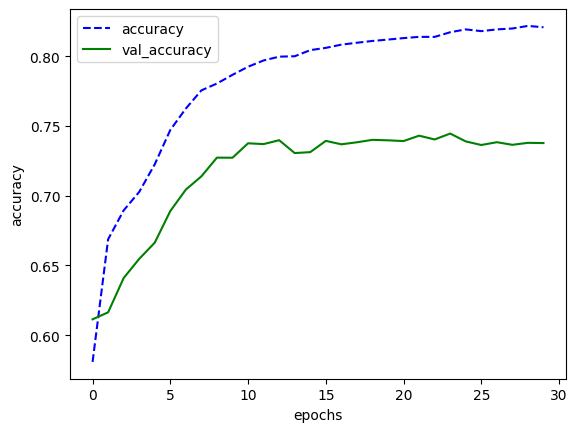

In [15]:
class PositionalEncodingLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x, *args, **kwargs):
        steps, d_model = x.shape.as_list()[-2:]
        ps = np.zeros([100, 1], dtype=K.floatx())
        for tx in range(100):
            ps[tx, :] = [(2 / (100 - 1)) * tx - 1]

        ps_expand = K.expand_dims(K.constant(ps), axis=0)
        ps_tiled = K.tile(ps_expand, [K.shape(x)[0], 1, 1])

        x = K.concatenate([x, ps_tiled], axis=-1)
        return x

def translob_model(**kwargs):
    inputs = Input(shape=(kwargs.get('sequence_length', 100), 144))
    x = inputs
    x = layers.Conv1D(14,kernel_size=2,dilation_rate=1,activation='leaky_relu',padding='causal')(x)
    x = layers.Conv1D(14,kernel_size=2,dilation_rate=2,activation='leaky_relu',padding='causal')(x)
    x = layers.Conv1D(14,kernel_size=2,dilation_rate=4,activation='leaky_relu',padding='causal')(x)
    x = layers.Conv1D(14,kernel_size=2,dilation_rate=8,activation='leaky_relu',padding='causal')(x)
    x = layers.Conv1D(14,kernel_size=2,dilation_rate=16,activation='leaky_relu',padding='causal')(x)
    x = layers.LayerNormalization()(x)
    x = PositionalEncodingLayer()(x)
    tb = TransformerBlock('tb1', kwargs.get('num_attention_heads', 3), True)
    blocks = kwargs.get('num_transformer_blocks', 2)
    for block in range(blocks):
        if kwargs.get('transformer_blocks_share_weights', True):
            x = tb(x)
        else:
            x = TransformerBlock(f'transformer_block_{block}', kwargs.get('num_attention_heads', 3), True)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64,activation='leaky_relu',kernel_regularizer='l2',kernel_initializer='glorot_uniform')(x)
    x = layers.Dropout(kwargs.get('dropout_rate', 0.1))(x)
    out = layers.Dense(3, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=out)
    model.summary()

    model.compile(
        tf.keras.optimizers.Adam(
            learning_rate=kwargs.get('lr', 0.0001),
            beta_1=kwargs.get('adam_beta1', 0.9),
            beta_2=kwargs.get('adam_beta2', 0.999),
            name="Adam",
        ),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['sparse_categorical_accuracy'],
    )

    return model

def train_translob(X_train, y_train, X_val, y_val, **kwargs):
    print('Train', X_train.shape, y_train.shape, 'Val', X_val.shape, y_val.shape)
    model = translob_model(**kwargs)
    length = kwargs.get('sequence_length', 100)
    train_gen = TimeseriesGenerator(X_train, y_train, length, shuffle=True, batch_size=kwargs.get('batch_size', 32))
    val_gen = TimeseriesGenerator(X_val, y_val, length, batch_size=kwargs.get('batch_size', 32))

    history = model.fit(
        train_gen,
        epochs=kwargs.get('epochs', 100),
        callbacks=[
            tf.keras.callbacks.TensorBoard(log_dir=(
                    "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
            ),
            tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', patience=10, min_delta=0.0002),
            EarlyStopping(monitor='val_sparse_categorical_accuracy', min_delta=0.001, patience=10, verbose=1, mode='auto')
        ],
        validation_data=val_gen
    )
    return model, history

def eval(model, X_test, y_test, **kwargs):
    ts = TimeseriesGenerator(X_test, y_test, kwargs.get('sequence_length', 100), batch_size=32, shuffle=False)
    y_true = np.concatenate([y for x, y in ts])
    y_pred = np.argmax(model.predict(ts), -1)
    print(classification_report(y_true, y_pred))
    return classification_report(y_true, y_pred, output_dict=True)['weighted avg']['f1-score']


(X_train, y_train), (X_val, y_val), (X_test, y_test) = load_dataset(horizon=4)

params = {
    # inputs
    'sequence_length': 100,
    # model
    'num_conv_filters': 14,
    'max_conv_dilation': 16,
    'num_attention_heads': 3,
    'num_transformer_blocks': 2,
    'transformer_blocks_share_weights': True,
    'dropout_rate': 0.1,
    # training
    'lr': 3e-4,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'batch_size': 16,
    'epochs': 30
}


model, history = train_translob(X_train, y_train, X_val, y_val, **params)
eval(model, X_test, y_test, **params)

plt.plot(history.history['sparse_categorical_accuracy'], '--b',label='accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], 'g', label='val_accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

#### Данная модель показала себя намного лучше модели из статьи. В частности, видно, что результат работы на тестовом датасете лучше, чем на валидационном. Лучший результат вероятно обусловлен использованием всех признаков из Limit order book, настройкой гиперпараметров и небольшим изменением архитектуры - функция активации ReLU на скрытых слоях заменена на Leaky ReLU. Изменены следующие значения гиперпараметров: learning_rate = 3e-4 (нередко используется для оптимизатора Adam), batch_size = 16 (позволяет обучать модель на небольших порциях данных), epochs = 30.  